# **VAE on Simple Autoencoder**

**Variational Autoencoder (VAE):</br>**
- VAEs are a type of neural network architecture used for unsupervised learning of latent representations of data.
- They consist of an encoder network, a decoder network, and a loss function that encourages the learned latent space to follow a specific distribution, typically a Gaussian distribution.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, losses
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load the MNIST dataset.

In [ ]:
# Load the MNIST dataset
from keras.datasets import mnist
import numpy as np

(train_images, _), (test_images, _) = mnist.load_data()
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
# Normalization-helps in training neural networks more effectively by keeping the input values within a smaller, more manageable range.

# Define encoder architecture
latent_dim = 2  # Dimensionality of latent space
# we want to compress the input data into a 2-dimensional space.

# the choice of a 2-dimensional latent space strikes a balance between visualization, interpretability, computational efficiency, and the ability to capture important features of the data.

11490434/11490434 [==============================] - 1s 0us/step


# **why did i use 2 latent dim:**
- Visualization: A 2-dimensional latent space can be easily visualized in a scatter plot, allowing you to explore and understand the learned representations. This visualization can provide insights into how the VAE compresses and decompresses the input data.

- Interpolation: With only 2 dimensions, it's easier to interpolate between latent vectors. This means you can smoothly transition between different latent representations, resulting in smooth transitions between generated images. For example, you can generate images that morph gradually from one digit to another.

- Simplicity: A 2-dimensional latent space keeps the model relatively simple and interpretable. It reduces the number of parameters in the model and makes training more tractable, especially for smaller datasets like MNIST.

- Feature Space Compression: For simpler datasets like MNIST, a 2-dimensional latent space may be sufficient to capture most of the relevant information in the input images while still providing meaningful latent representations.

# Define the encoder architecture.

**Latent Space:**</br>
- The latent space is a low-dimensional representation of the input data where each point corresponds to a different configuration or encoding of the input.

In [ ]:
# Define encoder architecture
encoder_inputs = layers.Input(shape=(28, 28))
# shape of 28x28 pixels.
x = layers.Flatten()(encoder_inputs)
# flattens the 28x28 input images into a vector of shape (784,). It converts the 2D image into a 1D array,
x = layers.Dense(256, activation='relu')(x)
# fully connected layer
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
# These are two dense layers without any activation function
# These layers are responsible for computing the mean and the log variance of the latent distribution
# they output 2 as our latent space=2

# 1 input layer, 1 hidden layer, and 2 output layers.

**Flatten Layer:**</br>
This layer flattens the 28x28 input images into a vector of shape (784,).</br>

**Dense Layer with ReLU Activation:**</br>
This is a fully connected (dense) layer with 256 neurons and ReLU activation function.</br>

**Two Dense Layers without Activation:**</br>
These layers compute the mean and the log variance of the latent distribution, respectively. Each layer outputs a vector of size latent_dim, which is 2 in your case.

# <b>The reparameterization trick</b>
is a method used in variational autoencoders (VAEs) to enable backpropagation through the stochastic process of sampling from the latent space.

<b>Sampling Function:</b></br>
The sampling function takes two arguments, z_mean and z_log_var, which represent the mean and log variance of the latent distribution respectively.</br>
It generates random noise epsilon from a normal distribution with the same shape as z_mean and z_log_var.</br>
It computes the sampled latent vector z using the formula: z = z_mean + tf.exp(0.5 * z_log_var) * epsilon.

<b>Lambda Layer:</b></br>
The Lambda layer in Keras is used to perform arbitrary operations on the input tensors.</br>
In this code, a Lambda layer is used to apply the sampling function to the input tensors [z_mean, z_log_var], resulting in the sampled latent vector z.

In [ ]:
# Reparameterization trick
# train the VAE end-to-end via gradient descent.
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])
# The Lambda layer takes the mean and log variance tensors ([z_mean, z_log_var]) as input and produces the sampled latent vector (z) as output.

**Reparameterization Trick:**

- In traditional autoencoders, the encoder directly outputs the parameters (mean and variance) of a Gaussian distribution in the latent space.
- However, this makes it challenging to perform backpropagation through the sampling process, as sampling is a non-differentiable operation.
- The reparameterization trick addresses this issue by decoupling the randomness from the parameters of the distribution.
- The sampling function generates samples from a Gaussian distribution using the provided mean and log variance while ensuring that the sampling operation remains differentiable.
- By using this trick, we can train the VAE end-to-end via gradient descent.

the reparameterization trick is crucial for training variational autoencoders effectively by enabling the sampling operation to be differentiable, thereby facilitating end-to-end training via gradient descent. Without it, the model would likely encounter optimization difficulties and struggle to learn meaningful latent representations of the input data.

In [ ]:
# Define encoder model
encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
# 784*256+256=200960
# 256*2+2=514

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28)]             0         []                            
                                                                                                  
 flatten (Flatten)           (None, 784)                  0         ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 256)                  200960    ['flatten[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 2)                    514       ['dense[0][0]']               
                                                                                            

- It takes encoder_inputs as the input layer, which represents the input images (28x28 pixels).
- The input images are flattened using a Flatten layer to convert them into a 1D vector.
- The flattened input vector is then passed through two fully connected (Dense) layers with ReLU activation functions.
- Two additional Dense layers are added to produce the mean (z_mean) and log variance (z_log_var) of the latent space representation.
- Finally, the reparameterization trick is applied using a Lambda layer to sample from the latent space based on the mean and log variance.

# **Output:**
- Number of Layers: 5 (1 Flatten layer, 3 Dense layers, and 1 Lambda layer)
- Hidden Layer(s): 3 (Dense layers with ReLU activation)
- Output Shape: (None, 2) for the mean, log variance, and latent space representation

# Define the decoder architecture.

In [ ]:
# Define decoder architecture
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(256, activation='relu')(latent_inputs)
x = layers.Dense(28 * 28, activation='sigmoid')(x)
# 784 neurons with a sigmoid activation function. It maps the higher-dimensional representation back to the original dimensionality of the input images (28x28 = 784 pixels).
# sigmoid=output layer
decoder_outputs = layers.Reshape((28, 28))(x)
# reshape the output of the second Dense layer to match the original shape of the input images
decoder = models.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 256)               768       
                                                                 
 dense_4 (Dense)             (None, 784)               201488    
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 202256 (790.06 KB)
Trainable params: 202256 (790.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**output:**
- Layer Types: The architecture consists of one Input layer, two Dense layers, and one Reshape layer.

# **EXPLAINATION**
**1- Input Layer:**</br>
  The input layer receives input from the latent space with a shape of (2,). It represents the latent space representation of input images.</br>

**2- Dense Layers:**</br>
  The first dense layer (dense_18) has 256 neurons with a ReLU activation function. It processes the input from the latent space.</br>
  The second dense layer (dense_19) has 784 neurons, which is equivalent to the flattened shape of the original input images (28x28 = 784).</br>
  It reconstructs the flattened image representation.
</br>
**3- Reshape Layer:**
  The reshape layer (reshape) converts the flattened output of the previous dense layer back into the original 2D shape of the input images (28x28).</br>
  This step is necessary to obtain the final reconstructed images.</br>
</br>
# **Summary:**
  The decoder model architecture consists of two dense layers and a reshape layer.</br>
  The total number of parameters in the decoder is 202,256, with all parameters being trainable.</br>
  The decoder model is responsible for generating reconstructed images from the latent space representations obtained from the encoder.

# Define the VAE model by combining the encoder and decoder.

In [ ]:
# Define VAE model

# encoder_inputs: This represents the input to the encoder model, which is the original input image data.
# encoder(encoder_inputs): This passes the input images through the encoder model, resulting in three outputs: z_mean, z_log_var, and z.
# decoder(encoder(encoder_inputs)[2]): This line takes the sampled latent vectors z obtained from the encoder model and passes them through the decoder model to generate reconstructed images.

outputs = decoder(encoder(encoder_inputs)[2])
vae = models.Model(encoder_inputs, outputs, name='vae')
vae.summary()



# input layer=original image=28*28=784
# encoder=z_mean,z_log_var,z
      #z_mean: The mean of the latent space distribution.
      #z_log_var: The log variance of the latent space distribution.
      #z: The sampled latent vector.
# decoder=takes the z from the encoder to generate new images

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28)            202256    
                                                                 
Total params: 404244 (1.54 MB)
Trainable params: 404244 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- encoder_inputs: The input layer for the encoder, which expects input images of shape (28, 28).

- encoder: The encoder model that processes the input images and produces three outputs:

- z_mean: The mean of the latent space distribution.
- z_log_var: The log variance of the latent space distribution.
- z: The sampled latent vector.
- decoder: The decoder model that reconstructs the input images from the latent - space representation. It takes the sampled latent vector as input and outputs reconstructed images of shape (28, 28).

- outputs: The output of the VAE, which is obtained by passing the sampled latent vector through the decoder.

= vae: The complete VAE model, which takes input images and produces reconstructed images. It combines the encoder and decoder models.

- The summary of the VAE model provides information about the architecture and parameters of each component:

- Total params: The total number of trainable parameters in the VAE model, which includes the parameters of both the encoder and decoder.

- Trainable params: The number of trainable parameters that will be updated during training.

- Non-trainable params: The number of parameters that are not trainable, typically corresponding to the parameters of layers like Flatten or Reshape, which don't have weights.

Overall, the VAE model encapsulates the entire architecture for learning a latent space representation of input images and generating reconstructed images from that latent space.-

# **EXPLAINATION**
**1- Input Layer:**
  The input layer receives input images with a shape of (28, 28). It serves as the entry point for data into the VAE.

**2- Encoder (Functional Model):**
  The encoder model is a functional model that takes input from the input layer and produces three outputs:
   - z_mean: Mean of the latent space representation.
   - z_log_var: Log-variance of the latent space representation.
   - z: Sampled latent space representation obtained using the reparameterization trick.
  The encoder model architecture is defined separately and is reused here.

**3- Decoder (Functional Model):**
   - The decoder model is a functional model that takes input from the latent space representation (z) and produces reconstructed images.
   - The decoder model architecture is defined separately and is reused here.

**Summary:**
   - The VAE model consists of an input layer, encoder model, and decoder model.- The encoder and decoder models are combined using functional API to create the VAE.
   - The total number of parameters in the VAE is the sum of parameters in the encoder and decoder, which is 404,244.
   - The VAE model is responsible for end-to-end training and generation of reconstructed images from input images.

# Define the VAE loss function.

- The reconstruction loss ensures that the VAE can accurately reconstruct input images. By minimizing this loss, the VAE learns to generate outputs that closely resemble the original inputs.

- The KL divergence loss regularizes the latent space of the VAE. It ensures that the distribution of latent variables learned by the encoder follows a known distribution, typically a standard normal distribution.

In [ ]:
# Define VAE loss function
def vae_loss(inputs, outputs):
# It takes two arguments: inputs and outputs, which represent the input images and the reconstructed outputs from the VAE, respectively.

    reconstruction_loss = losses.binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(outputs)) * 28 * 28

#This part calculates the reconstruction loss using binary cross-entropy. It measures the difference between the input images and the reconstructed outputs.

    # Retrieve z_mean and z_log_var from encoder outputs
    z_mean, z_log_var, _ = encoder(inputs)

    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    # regularize the latent space.
# calculates the Kullback-Leibler (KL) divergence between the distribution of the latent space variables and a standard normal distribution.
# This term regularizes the latent space, encouraging it to follow a Gaussian distribution.
    return tf.reduce_mean(reconstruction_loss + kl_loss)

# Compile VAE model
vae.compile(optimizer='adam', loss=vae_loss)


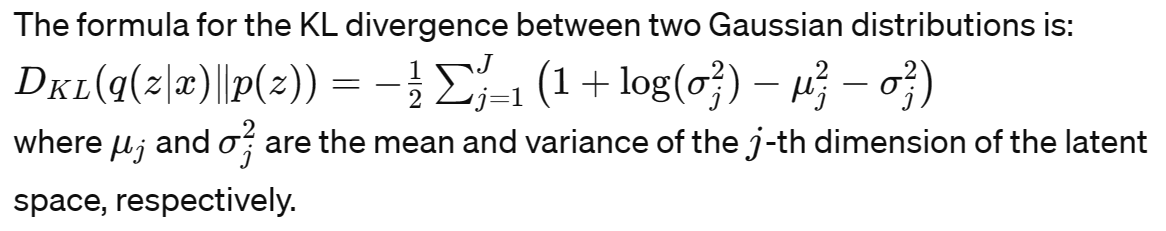

In [ ]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/formula.PNG')


In summary, the VAE loss function combines a reconstruction loss term and a KL divergence term. The reconstruction loss ensures that the model can accurately reconstruct input images, while the KL divergence term encourages the latent space to have a desired distribution. This setup allows the VAE to learn meaningful representations of the input data while regularizing the latent space.


# VAE Loss Function:
 - The VAE loss function combines two components:
 - Reconstruction Loss: Calculated using binary cross-entropy between the input and output images.
  This measures how well the reconstructed images match the original input images.
  - KL Divergence Loss: Measures the discrepancy between the learned latent space distribution and the unit Gaussian distribution.
 It encourages the latent space to follow a standard normal distribution.
 - The reconstruction loss is multiplied by the number of pixels in the input images (28 * 28) to scale it appropriately.
 - The KL divergence loss term is calculated using the mean and log-variance obtained from the encoder outputs.
 - The final loss is the mean of the reconstruction loss and KL divergence loss.

# Compiling VAE Model:
 - The VAE model is compiled with the Adam optimizer and the defined VAE loss function.
 - Adam optimizer is commonly used for training neural networks as it efficiently adapts learning rates.
 - The VAE model is now ready for training with the specified optimizer and loss function.

# Summary:
 - The VAE loss function consists of a reconstruction loss and a KL divergence loss.
 - The VAE model is compiled with the Adam optimizer and the defined loss function, preparing it for training.
 - This step is essential for specifying how the model should be trained and optimized during the training process.

we flatten both the inputs and outputs tensors before passing them to the binary_crossentropy function to ensure their shapes are compatible

# Train the VAE model.

In [ ]:
# Train the VAE model
vae.fit(train_images, train_images, epochs=10, batch_size=128)


Epoch 1/10
469/469 [==============================] - 9s 15ms/step - loss: 204.6460
Epoch 2/10
469/469 [==============================] - 8s 18ms/step - loss: 171.2884
Epoch 3/10
469/469 [==============================] - 8s 17ms/step - loss: 167.4089
Epoch 4/10
469/469 [==============================] - 7s 16ms/step - loss: 165.0275
Epoch 5/10
469/469 [==============================] - 8s 18ms/step - loss: 163.1320
Epoch 6/10
469/469 [==============================] - 7s 15ms/step - loss: 161.4782
Epoch 7/10
469/469 [==============================] - 12s 25ms/step - loss: 160.0521
Epoch 8/10
469/469 [==============================] - 12s 25ms/step - loss: 158.9363
Epoch 9/10
469/469 [==============================] - 8s 18ms/step - loss: 158.0022
Epoch 10/10
469/469 [==============================] - 10s 21ms/step - loss: 157.2810


save the model


In [ ]:
import tensorflow as tf
from tensorflow import keras
from google.colab import drive
drive.mount('/content/drive')

from keras.models import load_model
MODEL_PATH = './drive/My Drive/VAEMIDSIMPLE.h5'
vae.save(MODEL_PATH)

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

# Register the custom loss function
custom_objects = {'vae_loss': vae_loss}

# Load the model with custom loss function
SavedVAESimple = load_model(MODEL_PATH, custom_objects=custom_objects)

# Now you can use the loaded model for predictions
newdecoded_imgs = SavedVAESimple.predict(test_images)

313/313 [==============================] - 2s 6ms/step


# Generate images using the trained VAE model.

1/1 [==============================] - 0s 90ms/step


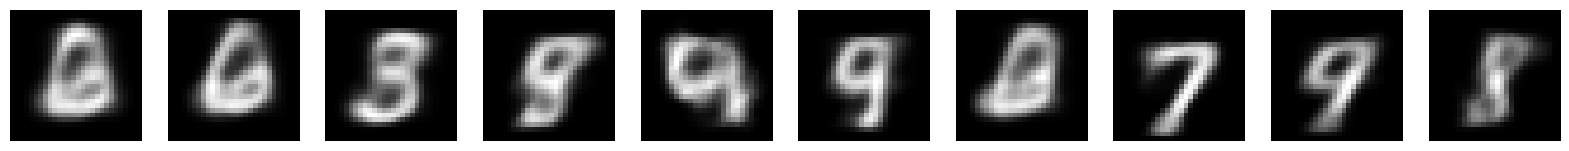

In [ ]:
# Generate images using VAE
num_images_to_generate = 10
random_latent_vectors = tf.random.normal(shape=(num_images_to_generate, latent_dim))
generated_images = decoder.predict(random_latent_vectors)
# use the trained decoder model (decoder) to predict or generate images based on the random latent vectors (random_latent_vectors).
# The decoder model takes these random vectors as input and generates corresponding images


# the decoder was trained to reconstruct images from latent vectors during training,
#  it has learned to decode these vectors into meaningful images.


# Plot the generated images
plt.figure(figsize=(20, 4))
for i in range(num_images_to_generate):
    ax = plt.subplot(1, num_images_to_generate, i + 1)
    plt.imshow(generated_images[i], cmap='gray')
    plt.axis('off')
plt.show()

- Generating Random Latent Vectors: Random vectors are sampled from a normal distribution in the latent space. These vectors serve as input to the decoder.

- Generating Images: The decoder takes the random latent vectors as input and generates corresponding images. Since the decoder was trained to reconstruct images from latent vectors during training, it can now generate new images by decoding these random vectors.

This code snippet generates random latent vectors, passes them through the decoder model to generate images, and then plots the generated images. This demonstrates the VAE's ability to generate new images by sampling from the learned latent space distribution. Each time you run this code, it will generate different images due to the stochastic nature of the latent space sampling.

on a bigger scope

1/1 [==============================] - 0s 24ms/step


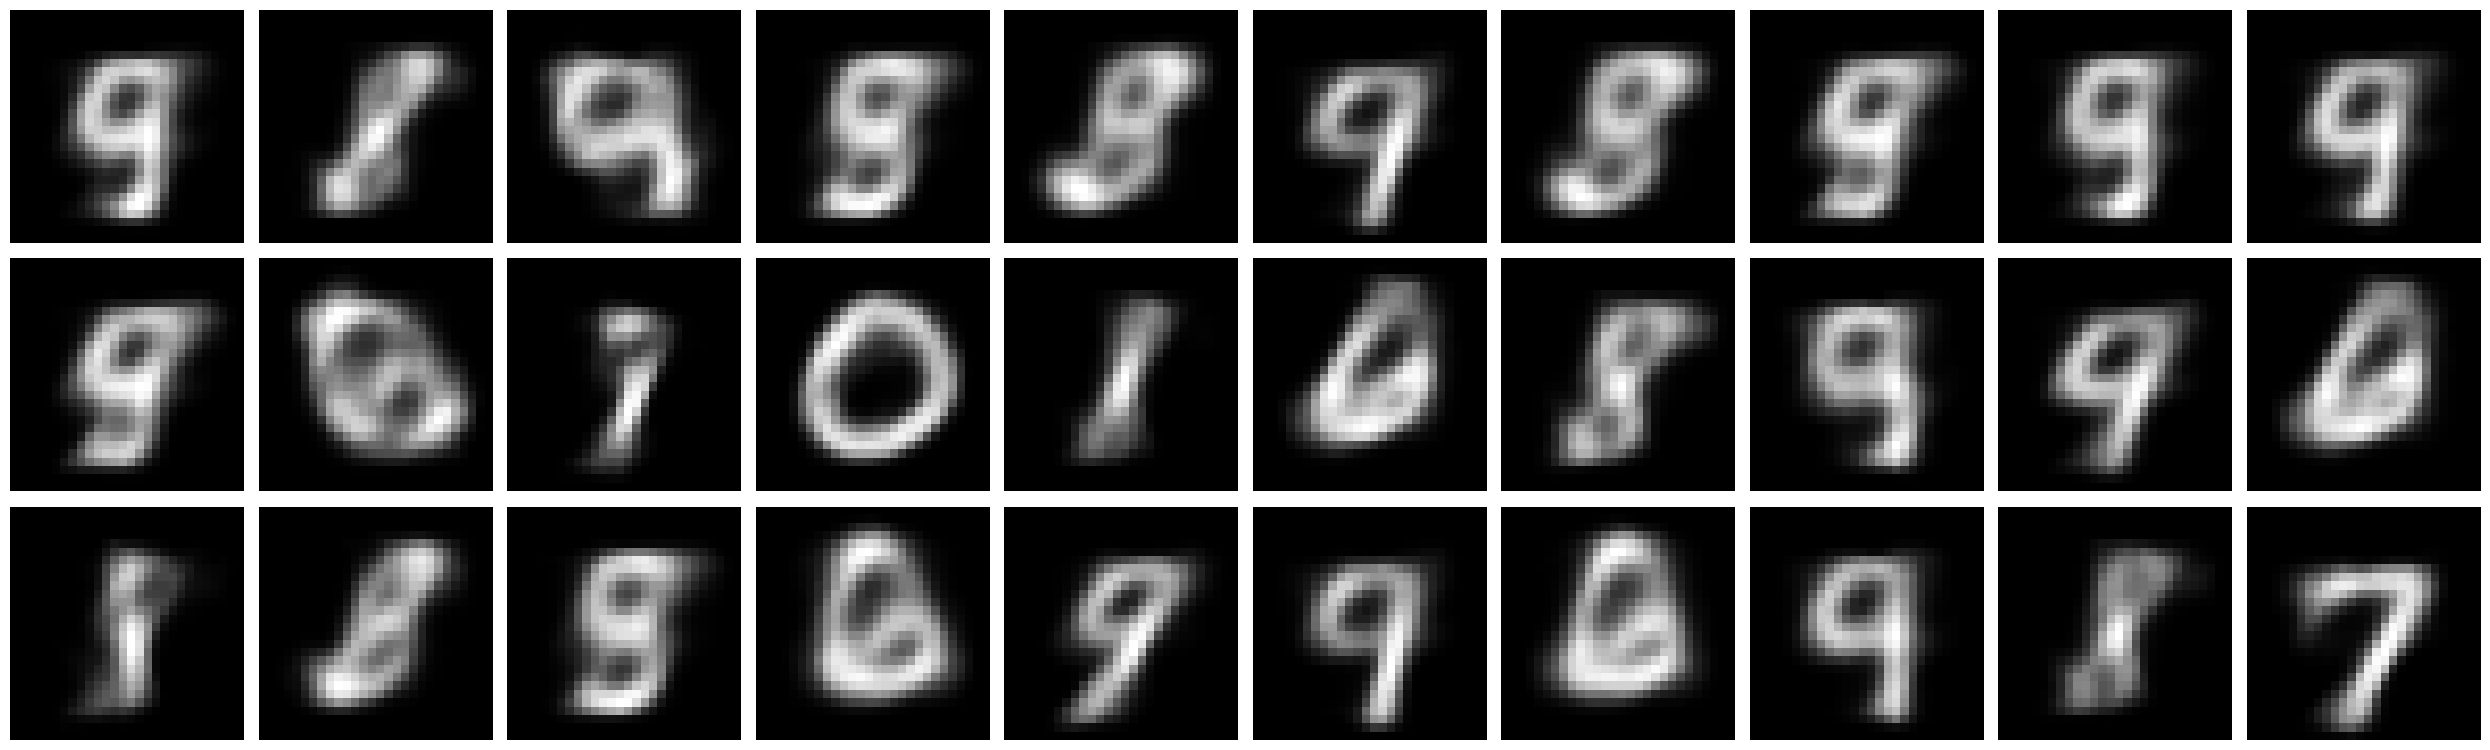

In [ ]:
# Generate images using the trained VAE model
num_images_to_generate = 30
random_latent_vectors = tf.random.normal(shape=(num_images_to_generate, latent_dim))
generated_images = decoder.predict(random_latent_vectors)

# Plot the generated images in a grid
plt.figure(figsize=(25, 25))
for i in range(num_images_to_generate):
    plt.subplot(10, 10, i + 1)
    plt.imshow(generated_images[i], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

313/313 [==============================] - 3s 9ms/step - loss: 157.3376
Reconstruction Loss: 157.33761596679688
313/313 [==============================] - 2s 6ms/step


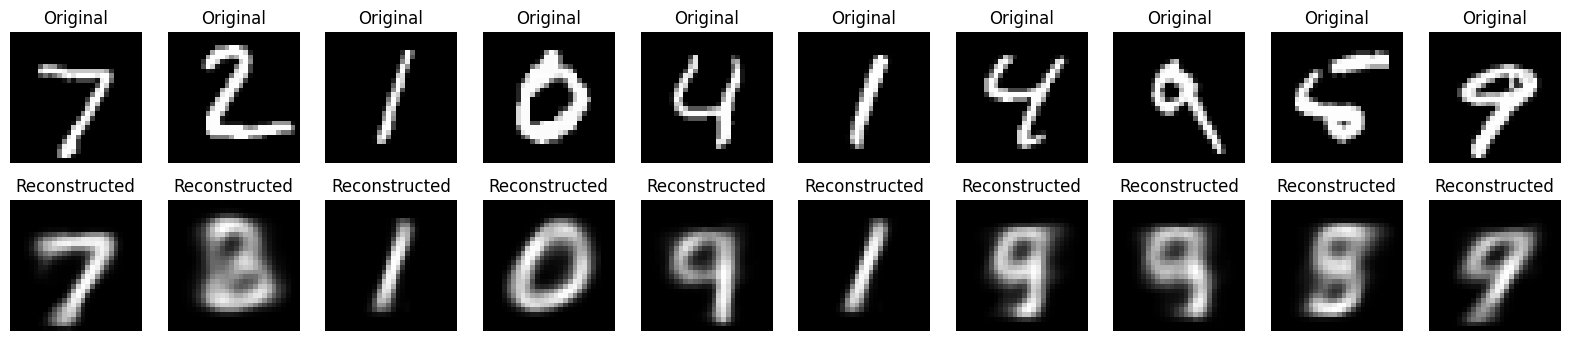

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Evaluate reconstruction loss on test data
reconstruction_loss = vae.evaluate(test_images, test_images)
print("Reconstruction Loss:", reconstruction_loss)

# Generate reconstructed images
reconstructed_images = vae.predict(test_images)

# Visualize original and reconstructed images
num_images_to_visualize = 10
plt.figure(figsize=(20, 4))
for i in range(num_images_to_visualize):
    # Plot original images
    plt.subplot(2, num_images_to_visualize, i + 1)
    plt.imshow(test_images[i], cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Plot reconstructed images
    plt.subplot(2, num_images_to_visualize, i + num_images_to_visualize + 1)
    plt.imshow(reconstructed_images[i], cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')
plt.show()

313/313 [==============================] - 1s 2ms/step


<ipython-input-45-e8b99bda7e1f>:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(z_mean[:, 0], z_mean[:, 1], cmap='viridis')


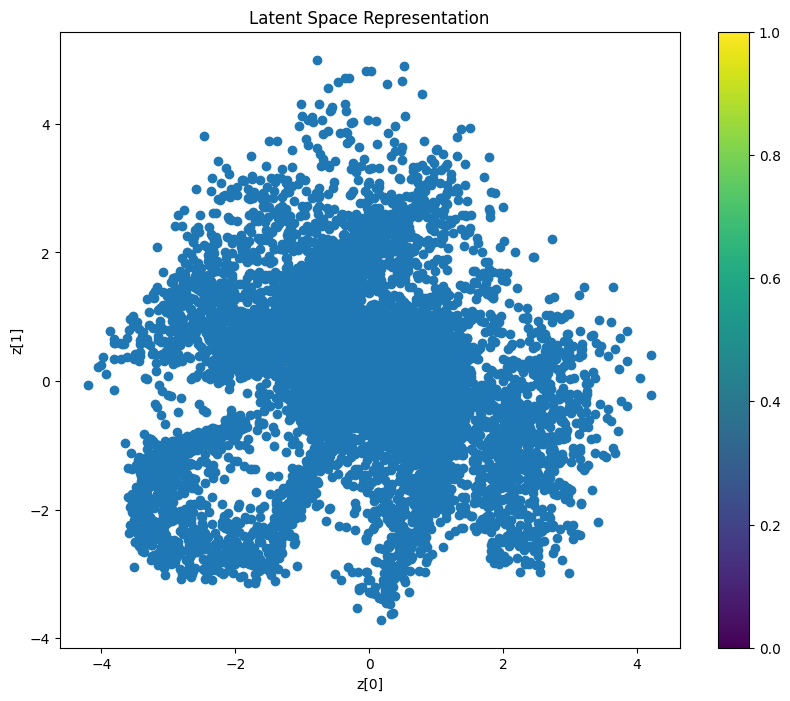

In [ ]:
# Visualize latent space representations
z_mean, _, _ = encoder.predict(test_images)
plt.figure(figsize=(10, 8))
plt.scatter(z_mean[:, 0], z_mean[:, 1], cmap='viridis')
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("Latent Space Representation")
plt.show()


313/313 [==============================] - 2s 6ms/step - loss: 157.3820
Reconstruction Loss: 157.3819580078125
313/313 [==============================] - 1s 5ms/step


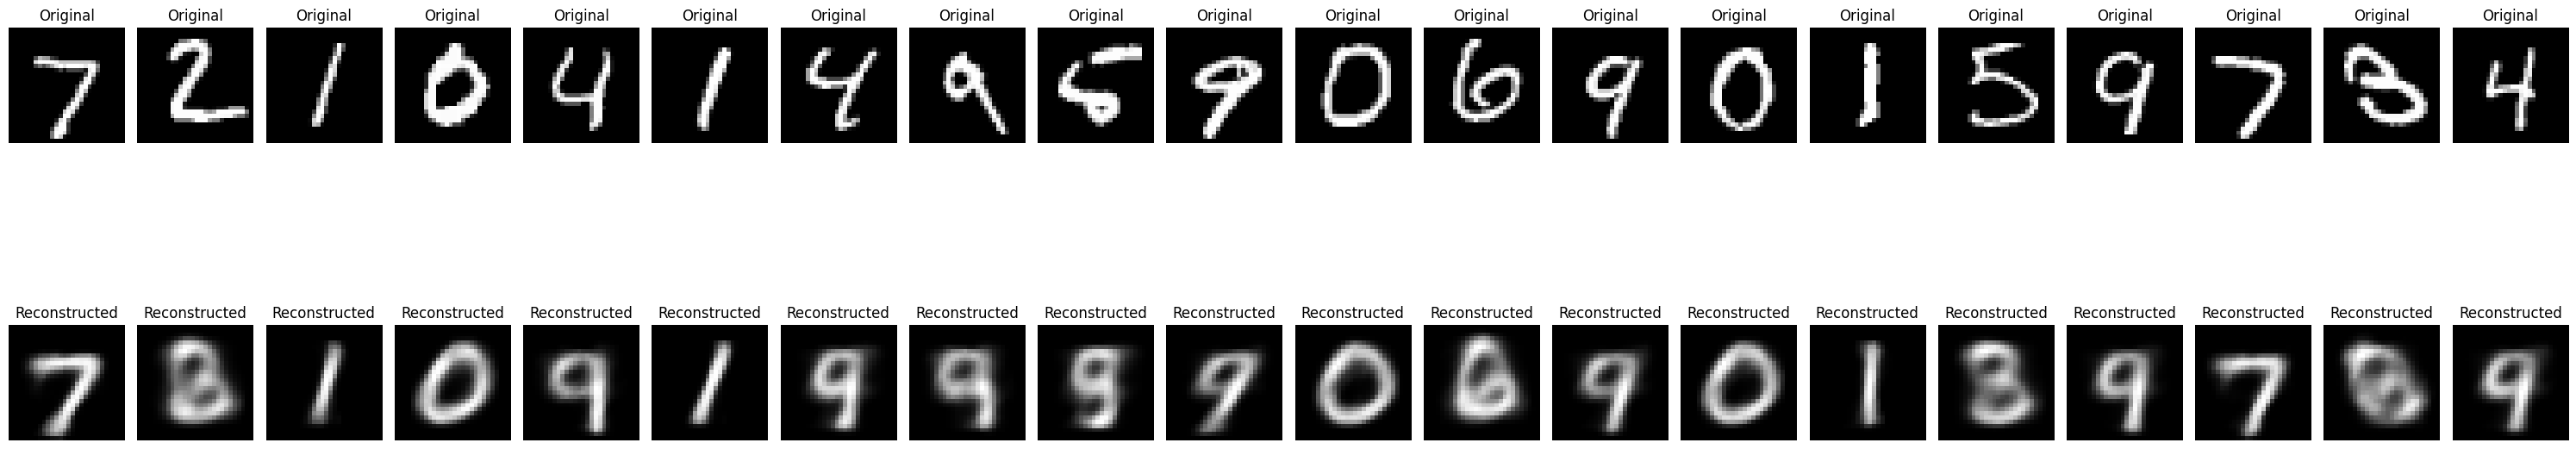

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Evaluate reconstruction loss on test data
reconstruction_loss = vae.evaluate(test_images, test_images)
print("Reconstruction Loss:", reconstruction_loss)

# Generate reconstructed images
reconstructed_images = vae.predict(test_images)

# Visualize original and reconstructed images
num_images_to_visualize = 20
plt.figure(figsize=(30, 9))

# Plot original images
for i in range(num_images_to_visualize):
    plt.subplot(2, num_images_to_visualize, i + 1)
    plt.imshow(test_images[i], cmap='gray')
    plt.title('Original')
    plt.axis('off')

# Plot reconstructed images
for i in range(num_images_to_visualize):
    plt.subplot(2, num_images_to_visualize, i + num_images_to_visualize + 1)
    plt.imshow(reconstructed_images[i], cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')

plt.tight_layout()
plt.show()


# **Fashion Mnist Simple Autoencoder**

In [ ]:
# Load the MNIST dataset
from keras.datasets import fashion_mnist
import numpy as np

(train_images, _), (test_images, _) = fashion_mnist.load_data()
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

# Define encoder architecture
latent_dim = 2  # Dimensionality of latent space

4422102/4422102 [==============================] - 1s 0us/step


In [ ]:
# Define encoder architecture
encoder_inputs = layers.Input(shape=(28, 28))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(256, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [ ]:
# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [ ]:
# Define encoder model
encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 28, 28)]             0         []                            
                                                                                                  
 flatten_1 (Flatten)         (None, 784)                  0         ['input_3[0][0]']             
                                                                                                  
 dense_5 (Dense)             (None, 256)                  200960    ['flatten_1[0][0]']           
                                                                                                  
 dense_6 (Dense)             (None, 2)                    514       ['dense_5[0][0]']             
                                                                                            

In [ ]:
# Define decoder architecture
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(256, activation='relu')(latent_inputs)
x = layers.Dense(28 * 28, activation='sigmoid')(x)
decoder_outputs = layers.Reshape((28, 28))(x)
decoder = models.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_8 (Dense)             (None, 256)               768       
                                                                 
 dense_9 (Dense)             (None, 784)               201488    
                                                                 
 reshape_1 (Reshape)         (None, 28, 28)            0         
                                                                 
Total params: 202256 (790.06 KB)
Trainable params: 202256 (790.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define VAE model
outputs = decoder(encoder(encoder_inputs)[2])
vae = models.Model(encoder_inputs, outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28)            202256    
                                                                 
Total params: 404244 (1.54 MB)
Trainable params: 404244 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define VAE loss function
def vae_loss(inputs, outputs):
    reconstruction_loss = losses.binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(outputs)) * 28 * 28

    # Retrieve z_mean and z_log_var from encoder outputs
    z_mean, z_log_var, _ = encoder(inputs)

    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)

    return tf.reduce_mean(reconstruction_loss + kl_loss)

# Compile VAE model
vae.compile(optimizer='adam', loss=vae_loss)


In [ ]:
# Train the VAE model
vae.fit(train_images, train_images, epochs=10, batch_size=128)


Epoch 1/10
469/469 [==============================] - 10s 19ms/step - loss: 309.9275
Epoch 2/10
469/469 [==============================] - 8s 16ms/step - loss: 279.9584
Epoch 3/10
469/469 [==============================] - 9s 19ms/step - loss: 275.5544
Epoch 4/10
469/469 [==============================] - 9s 19ms/step - loss: 272.7692
Epoch 5/10
469/469 [==============================] - 7s 15ms/step - loss: 271.0920
Epoch 6/10
469/469 [==============================] - 9s 19ms/step - loss: 269.8091
Epoch 7/10
469/469 [==============================] - 7s 15ms/step - loss: 268.9262
Epoch 8/10
469/469 [==============================] - 9s 19ms/step - loss: 268.0419
Epoch 9/10
469/469 [==============================] - 7s 16ms/step - loss: 267.3196
Epoch 10/10
469/469 [==============================] - 9s 19ms/step - loss: 266.6662


1/1 [==============================] - 0s 87ms/step


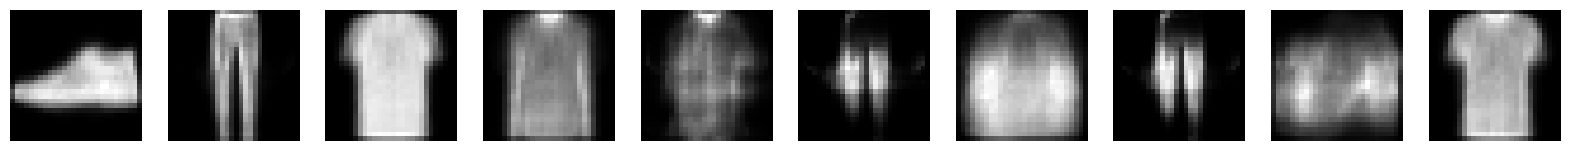

In [ ]:
# Generate images using VAE
num_images_to_generate = 10
random_latent_vectors = tf.random.normal(shape=(num_images_to_generate, latent_dim))
generated_images = decoder.predict(random_latent_vectors)

# Plot the generated images
plt.figure(figsize=(20, 4))
for i in range(num_images_to_generate):
    ax = plt.subplot(1, num_images_to_generate, i + 1)
    plt.imshow(generated_images[i], cmap='gray')
    plt.axis('off')
plt.show()

313/313 [==============================] - 1s 4ms/step - loss: 267.6347
Reconstruction Loss: 267.6347351074219
313/313 [==============================] - 1s 3ms/step


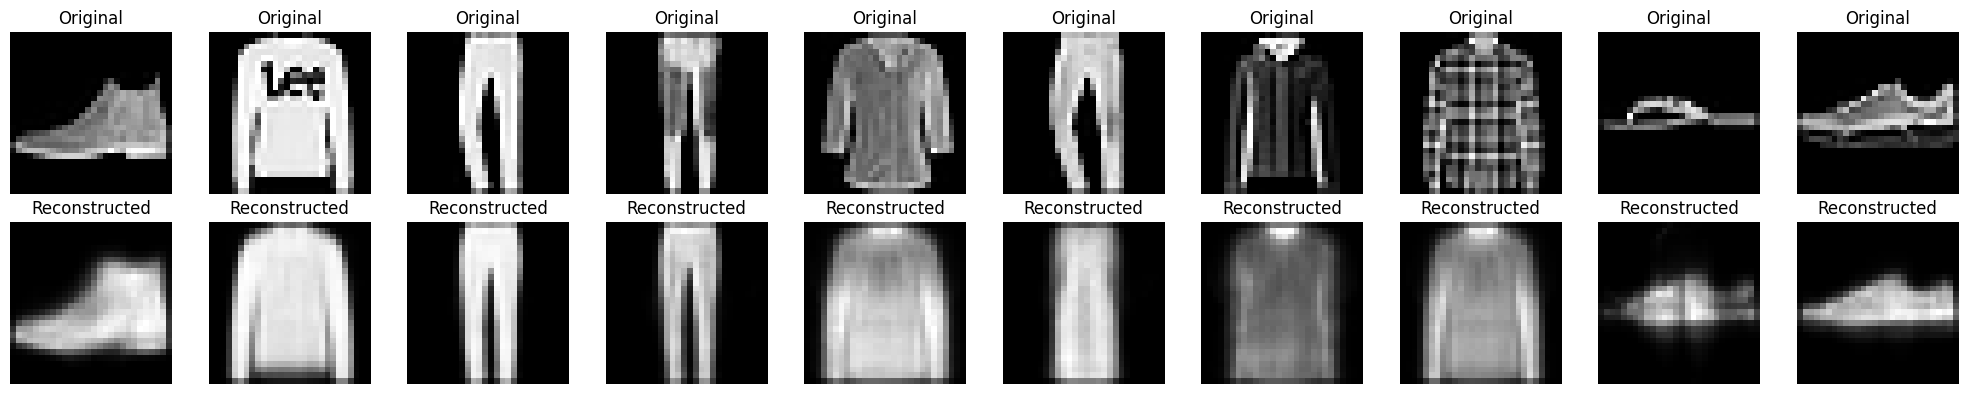

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Evaluate reconstruction loss on test data
reconstruction_loss = vae.evaluate(test_images, test_images)
print("Reconstruction Loss:", reconstruction_loss)

# Generate reconstructed images
reconstructed_images = vae.predict(test_images)

# Plot original and reconstructed images
num_images_to_visualize = 10
plt.figure(figsize=(20, 4))
for i in range(num_images_to_visualize):
    # Plot original images
    plt.subplot(2, num_images_to_visualize, i + 1)
    plt.imshow(test_images[i], cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Plot reconstructed images
    plt.subplot(2, num_images_to_visualize, i + num_images_to_visualize + 1)
    plt.imshow(reconstructed_images[i], cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')

plt.tight_layout()
plt.show()


# **VAE on Deep AutoEncoder**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load MNIST data
(x_train, _), (x_test, _) = mnist.load_data()



11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
# Normalize data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Flatten images
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))



In [ ]:
# Define encoder
input_dim = x_train.shape[1]
latent_dim = 2

encoder_inputs = layers.Input(shape=(input_dim,))
h = layers.Dense(128, activation='relu')(encoder_inputs)
h = layers.Dense(64, activation='relu')(h)
z_mean = layers.Dense(latent_dim)(h)
z_log_var = layers.Dense(latent_dim)(h)



In [ ]:
# Define sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], latent_dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')


In [ ]:

# Define decoder
latent_inputs = layers.Input(shape=(latent_dim,))
h = layers.Dense(64, activation='relu')(latent_inputs)
h = layers.Dense(128, activation='relu')(h)
decoder_outputs = layers.Dense(input_dim, activation='sigmoid')(h)

decoder = models.Model(latent_inputs, decoder_outputs, name='decoder')



In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 64)                192       
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 784)               101136    
                                                                 
Total params: 109648 (428.31 KB)
Trainable params: 109648 (428.31 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  100480    ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 64)                   8256      ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 2)                    130       ['dense_1[0][0]']             
                                                                                            

In [ ]:
# Define VAE
outputs = decoder(encoder(encoder_inputs)[2])
vae = models.Model(encoder_inputs, outputs, name='vae')


In [ ]:
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               108996    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               109648    
                                                                 
Total params: 218644 (854.08 KB)
Trainable params: 218644 (854.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define loss
reconstruction_loss = tf.keras.losses.binary_crossentropy(encoder_inputs, outputs)
reconstruction_loss *= input_dim
kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)



In [ ]:
# Compile model
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Train model
history = vae.fit(x_train, epochs=50, batch_size=128, validation_data=(x_test, None))


Epoch 1/50
469/469 [==============================] - 14s 21ms/step - loss: 205.9862 - val_loss: 177.4982
Epoch 2/50
469/469 [==============================] - 6s 12ms/step - loss: 172.9527 - val_loss: 169.3065
Epoch 3/50
469/469 [==============================] - 7s 15ms/step - loss: 167.5638 - val_loss: 166.1347
Epoch 4/50
469/469 [==============================] - 6s 12ms/step - loss: 164.6823 - val_loss: 163.8254
Epoch 5/50
469/469 [==============================] - 7s 15ms/step - loss: 162.5056 - val_loss: 161.6648
Epoch 6/50
469/469 [==============================] - 6s 13ms/step - loss: 160.2753 - val_loss: 159.1684
Epoch 7/50
469/469 [==============================] - 7s 15ms/step - loss: 157.9670 - val_loss: 157.1619
Epoch 8/50
469/469 [==============================] - 6s 13ms/step - loss: 156.1569 - val_loss: 155.5525
Epoch 9/50
469/469 [==============================] - 8s 16ms/step - loss: 154.9577 - val_loss: 154.4516
Epoch 10/50
469/469 [==============================] -

In [ ]:
import tensorflow as tf
from tensorflow import keras
from google.colab import drive
drive.mount('/content/drive')

from keras.models import load_model
MODEL_PATH = './drive/My Drive/VAEMIDDeep.h5'
vae.save(MODEL_PATH)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load Model
SavedAutoencoder  = load_model(MODEL_PATH)
newdecoded_imgs = SavedAutoencoder.predict(x_test)

313/313 [==============================] - 1s 3ms/step


# Original + Reconstructed

313/313 [==============================] - 1s 3ms/step


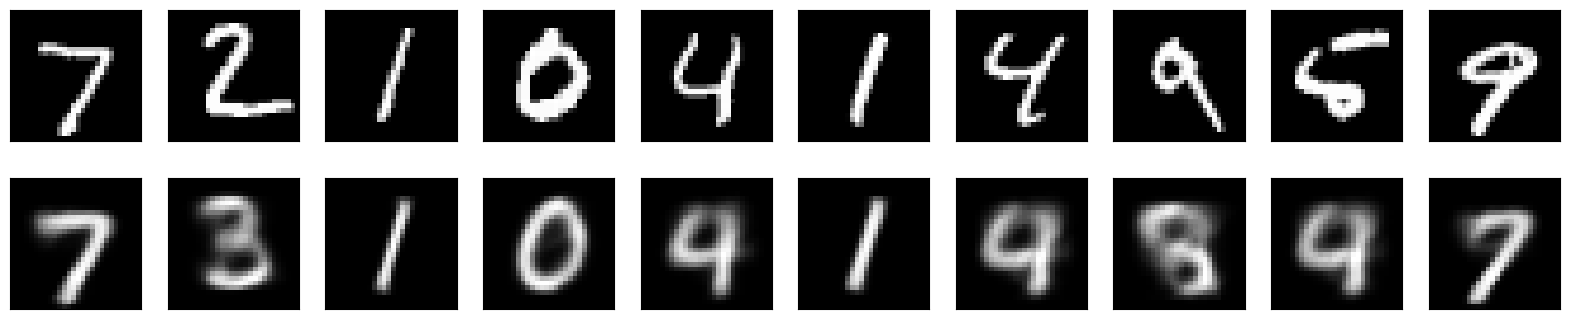

In [ ]:
# Generate images
decoded_imgs = vae.predict(x_test)

# Plot some reconstructed images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


# Random

1/1 [==============================] - 0s 22ms/step


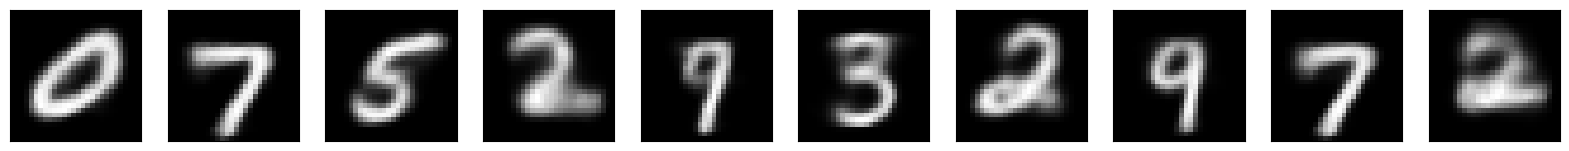

In [ ]:
# Sample random points from the latent space
random_latent_points = np.random.normal(size=(10, latent_dim))
decoded_imgs = decoder.predict(random_latent_points)

# Plot the generated images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


# Original + Random

1/1 [==============================] - 0s 23ms/step


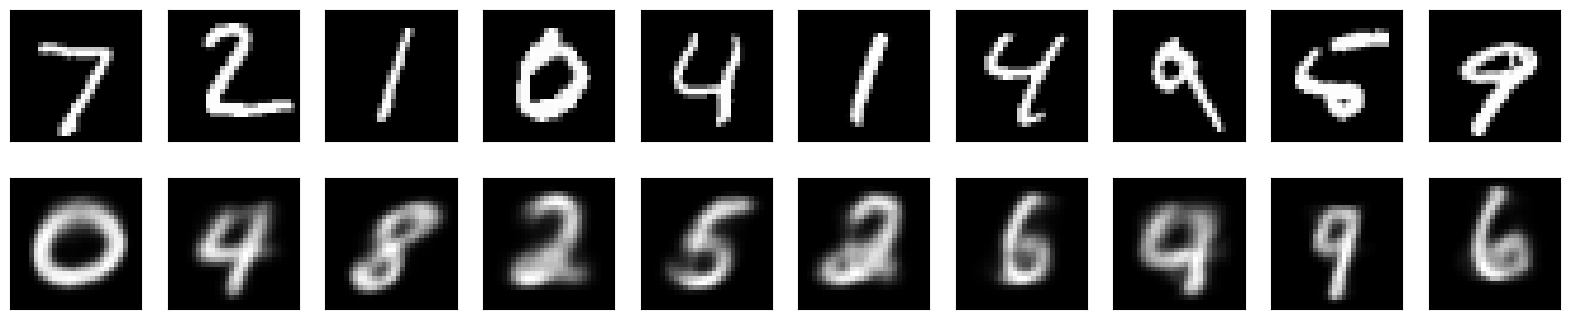

In [ ]:
# Sample random points from the latent space
random_latent_points = np.random.normal(size=(10, latent_dim))
decoded_imgs = decoder.predict(random_latent_points)

# Plot original and randomly generated images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Plot original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Plot randomly generated image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


# **VAE on Deep AutoEncoder with 4 latent_dim**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load MNIST data
(x_train, _), (x_test, _) = mnist.load_data()



In [ ]:
# Normalize data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Flatten images
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))



In [ ]:
# Define encoder
input_dim = x_train.shape[1]
latent_dim = 4

encoder_inputs = layers.Input(shape=(input_dim,))
h = layers.Dense(128, activation='relu')(encoder_inputs)
h = layers.Dense(64, activation='relu')(h)
z_mean = layers.Dense(latent_dim)(h)
z_log_var = layers.Dense(latent_dim)(h)



In [ ]:
# Define sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], latent_dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')


In [ ]:

# Define decoder
latent_inputs = layers.Input(shape=(latent_dim,))
h = layers.Dense(64, activation='relu')(latent_inputs)
h = layers.Dense(128, activation='relu')(h)
decoder_outputs = layers.Dense(input_dim, activation='sigmoid')(h)

decoder = models.Model(latent_inputs, decoder_outputs, name='decoder')



In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_14 (Dense)            (None, 64)                320       
                                                                 
 dense_15 (Dense)            (None, 128)               8320      
                                                                 
 dense_16 (Dense)            (None, 784)               101136    
                                                                 
Total params: 109776 (428.81 KB)
Trainable params: 109776 (428.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense_10 (Dense)            (None, 128)                  100480    ['input_4[0][0]']             
                                                                                                  
 dense_11 (Dense)            (None, 64)                   8256      ['dense_10[0][0]']            
                                                                                                  
 dense_12 (Dense)            (None, 4)                    260       ['dense_11[0][0]']            
                                                                                            

In [ ]:
# Define VAE
outputs = decoder(encoder(encoder_inputs)[2])
vae = models.Model(encoder_inputs, outputs, name='vae')


In [ ]:
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 4),               109256    
                              (None, 4),                         
                              (None, 4)]                         
                                                                 
 decoder (Functional)        (None, 784)               109776    
                                                                 
Total params: 219032 (855.59 KB)
Trainable params: 219032 (855.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define loss
reconstruction_loss = tf.keras.losses.binary_crossentropy(encoder_inputs, outputs)
reconstruction_loss *= input_dim
kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)



In [ ]:
# Compile model
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Train model
history = vae.fit(x_train, epochs=50, batch_size=128, validation_data=(x_test, None))


Epoch 1/50
469/469 [==============================] - 8s 14ms/step - loss: 190.5120 - val_loss: 156.8855
Epoch 2/50
469/469 [==============================] - 8s 16ms/step - loss: 152.0250 - val_loss: 146.7411
Epoch 3/50
469/469 [==============================] - 6s 13ms/step - loss: 144.3918 - val_loss: 141.6433
Epoch 4/50
469/469 [==============================] - 8s 17ms/step - loss: 140.6481 - val_loss: 138.6114
Epoch 5/50
469/469 [==============================] - 6s 13ms/step - loss: 138.2345 - val_loss: 136.8543
Epoch 6/50
469/469 [==============================] - 8s 17ms/step - loss: 136.5499 - val_loss: 135.3366
Epoch 7/50
469/469 [==============================] - 6s 12ms/step - loss: 135.2390 - val_loss: 134.3097
Epoch 8/50
469/469 [==============================] - 8s 16ms/step - loss: 134.1403 - val_loss: 133.4733
Epoch 9/50
469/469 [==============================] - 6s 12ms/step - loss: 133.2246 - val_loss: 132.6834
Epoch 10/50
469/469 [==============================] - 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from google.colab import drive
drive.mount('/content/drive')

from keras.models import load_model
MODEL_PATH = './drive/My Drive/VAEMIDDeep.h5'
vae.save(MODEL_PATH)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load Model
SavedAutoencoder  = load_model(MODEL_PATH)
newdecoded_imgs = SavedAutoencoder.predict(x_test)

313/313 [==============================] - 1s 3ms/step


# Original + Reconstructed

313/313 [==============================] - 1s 3ms/step


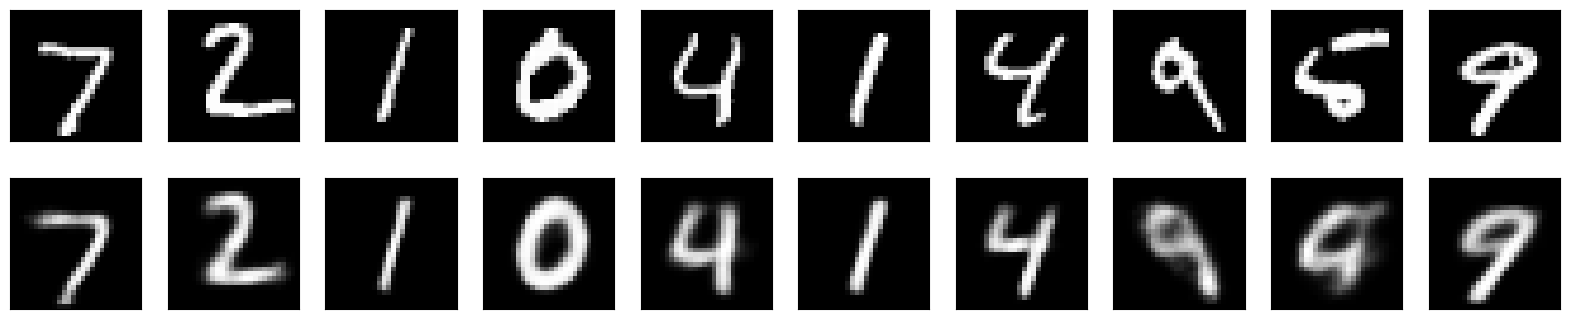

In [ ]:
# Generate images
decoded_imgs = vae.predict(x_test)

# Plot some reconstructed images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


# Random

1/1 [==============================] - 0s 60ms/step


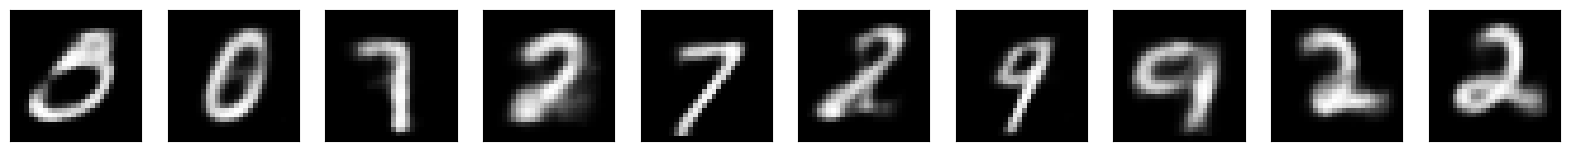

In [ ]:
# Sample random points from the latent space
random_latent_points = np.random.normal(size=(10, latent_dim))
decoded_imgs = decoder.predict(random_latent_points)

# Plot the generated images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


1/1 [==============================] - 0s 35ms/step


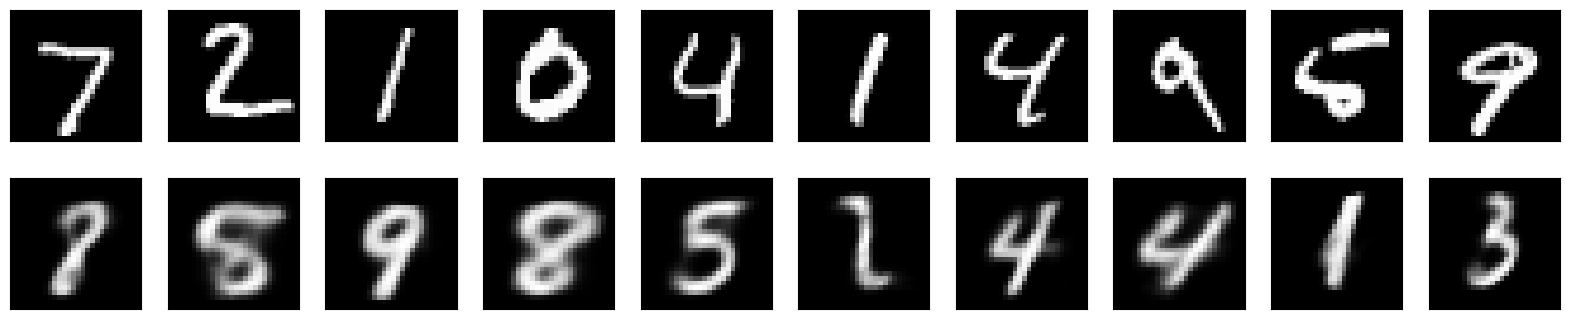

In [ ]:
# Sample random points from the latent space
random_latent_points = np.random.normal(size=(10, latent_dim))
decoded_imgs = decoder.predict(random_latent_points)

# Plot original and randomly generated images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Plot original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Plot randomly generated image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
